[Transfer learning with TensorFlow Hub  \|  TensorFlow Core](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub?hl=ja)

[TensorFlow Hub](https://www.tensorflow.org/hub?hl=ja)は学習済みモデルを共有するためのもの。学習済みモデルの検索は[TensorFlow Hub](https://tfhub.dev/)からできる。

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub

import matplotlib.pylab as plt

### ImageNet の分類器のダウンロード

In [2]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### 1枚の画像で実行する

65536/61306 [================================] - 0s 0us/step


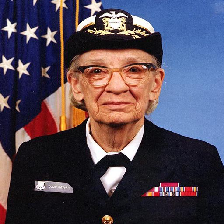

In [3]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

画像は 224x224 で、3チャネル (RGB) を持つ

In [4]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

出力は 1001 要素の配列で、各値が各ラベルの確率を表す

In [5]:
target = np.array([grace_hopper])
result = classifier.predict(target)
result.shape

(1, 1001)

最も確率の高いクラスIDを表示する

In [6]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

推論結果をデコードする

16384/10484 [==============================================] - 0s 0us/step


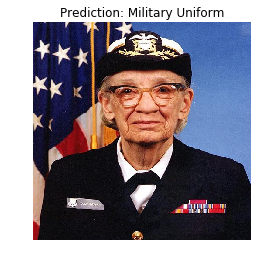

In [7]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
plt.title("Prediction: " + predicted_class_name.title())
plt.show()

### シンプルな転移学習

モデルの最上位層だけを再訓練する。

ここからは TensorFlow flowersデータセットを利用する。

In [8]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 4s 0us/step


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(
    str(data_root), 
    target_size=IMAGE_SHAPE)

# 結果のオブジェクトは image_batch, label_batch のペアを返すイテレーター
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


- 画像は (224, 224, 3) サイズが 32 枚ある
- ラベルは 5 種類で、32 枚の画像に対応している

### ImageNet の分類器で画像をバッチ処理してみる

In [10]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [11]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'coral fungus', 'hip', 'hip', 'daisy', 'alp', 'vase',
       'banana', 'goblet', 'ice cream', 'daisy', 'vase', 'hip', 'bubble',
       'daisy', 'pot', "yellow lady's slipper", 'daisy', 'daisy', 'bee',
       'daisy', 'barn spider', 'daisy', 'vase', 'handkerchief', 'wool',
       'tray', 'daisy', 'daisy', 'sea urchin', 'daisy', 'picket fence'],
      dtype='<U30')

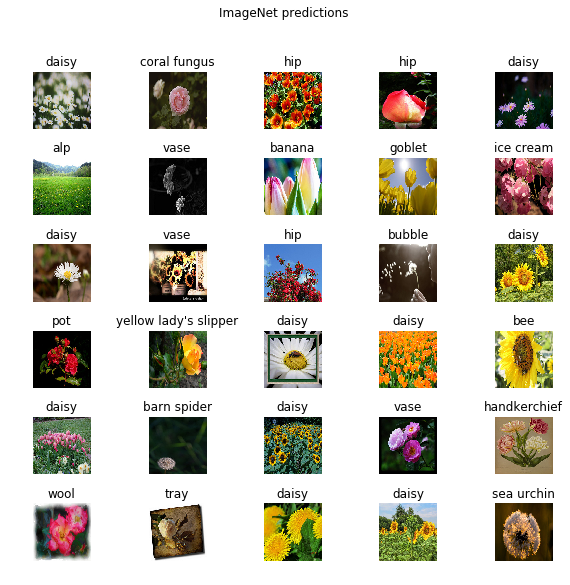

In [12]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
plt.suptitle("ImageNet predictions")
plt.show()

完璧とは程遠い結果ですが、このモデルはこれらのクラスのために訓練されたものではないため

### ヘッドレスモデルのダウンロード

In [13]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

# 特徴抽出器の作成
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

# 特徴抽出器は画像毎に長さ 1280 のベクトルデータを返す
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

# 特徴抽出レイヤーの変数をフリーズして、訓練が新しい分類器のレイヤーのみを変更するようにする
feature_extractor_layer.trainable = False

(32, 1280)


### 上位の分類層を接合する

ヘッドレスモデル（重み固定済み）の上位層に、（訓練可能な）Dense層を加える。

In [14]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


### モデルのコンパイル

- 損失関数 : ラベルはone-hotなので、`categorical_crossentropy`
- 評価指標 : 正解率 (accuracy; acc)

In [15]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

訓練のプロセスを可視化するために、各エポックの平均だけではなく各々のバッチで個別に損失と正確度を記録するためのカスタムコールバックを作る

In [16]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [17]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2, # 簡単にするために2エポックだけ
                              steps_per_epoch=steps_per_epoch,
                              callbacks=[batch_stats_callback])

Train for 115.0 steps
Epoch 1/2
115/115 [==============================] - 86s 747ms/step - loss: 0.6582 - acc: 0.8750
Epoch 2/2
115/115 [==============================] - 81s 701ms/step - loss: 0.3266 - acc: 0.9688


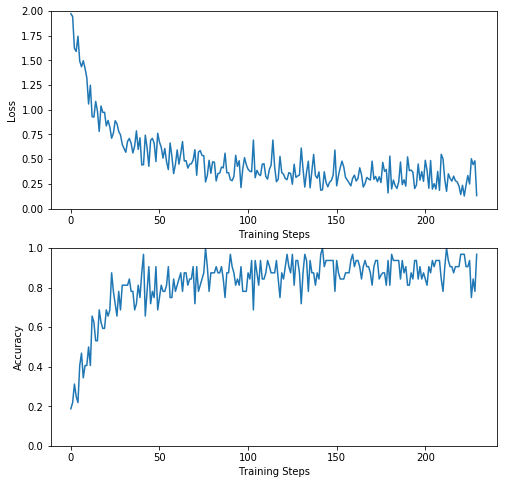

In [18]:
plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1)
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.subplot(2, 1, 2)
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

plt.show()

転移学習では、2エポックという数回の訓練の繰り返しでさえ、タスクにおいてモデルが進歩していることが分かる

### 推論結果の確認

まず、クラス名のリストを取得する

In [19]:
class_names = np.array([key for key in image_data.class_indices])
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

画像のバッチをモデルに入力し、得られた ID をクラス名に変換する

In [20]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

結果をプロットする

In [21]:
label_id = np.argmax(label_batch, axis=-1)

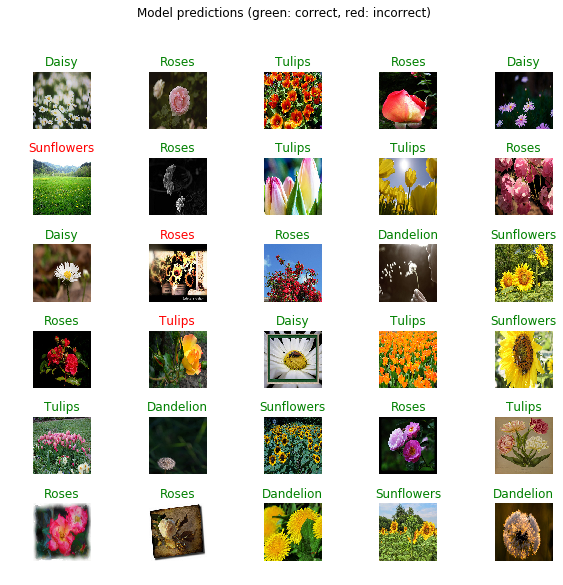

In [22]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.show()

### モデルのエクスポート

なお、保存したモデルは TFLite や TFjs のモデルに変換することもできる。

In [23]:
# import time
# t = time.time()
#
# export_path = "/tmp/saved_models/{}".format(int(t))
# model.save(export_path, save_format='tf')

### モデルのインポート

In [24]:
# model = tf.keras.models.load_model(export_path)